### Data Loading

In [1]:
import pandas as pd
import numpy as np
import csv

# import data
data = pd.read_csv("~/Downloads/healthcare/train_data.csv")


### Data pre-processing

In [2]:
# drop empty data
data = data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

# drop unimportant data
data = data.drop(columns=["case_id","Hospital_code","Hospital_type_code","City_Code_Hospital",
                          "Hospital_region_code","Department","Ward_Type","Ward_Facility_Code",
                          "patientid", "City_Code_Patient","Bed Grade"])
data


,Available Extra Rooms in Hospital,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,3,Emergency,Extreme,2,51-60,4911,0-10
1,2,Trauma,Extreme,2,51-60,5954,41-50
2,2,Trauma,Extreme,2,51-60,4745,31-40
3,2,Trauma,Extreme,2,51-60,7272,41-50
4,2,Trauma,Extreme,2,51-60,5558,41-50
...,...,...,...,...,...,...,...
318433,3,Emergency,Moderate,3,41-50,4144,20-Nov
318434,2,Urgent,Moderate,4,81-90,6699,31-40
318435,3,Emergency,Minor,3,71-80,4235,20-Nov
318436,3,Trauma,Minor,5,20-Nov,3761,20-Nov


In [3]:
# define stay time over 60 days as long-term, others as short-term
from sklearn.preprocessing import LabelEncoder

encoder= LabelEncoder().fit(data["Stay"])
data["Stay"] = encoder.transform(data["Stay"])

In [4]:
data["y"]= data["Stay"].apply(lambda x: 1 if x>=6 else 0)

In [5]:
# define X, y
y=data['y']
X=data.drop(['Stay','y'], axis=1)
X.head()


,Available Extra Rooms in Hospital,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,3,Emergency,Extreme,2,51-60,4911
1,2,Trauma,Extreme,2,51-60,5954
2,2,Trauma,Extreme,2,51-60,4745
3,2,Trauma,Extreme,2,51-60,7272
4,2,Trauma,Extreme,2,51-60,5558


In [6]:
y.value_counts()

0    286977
1     26816
Name: y, dtype: int64

<AxesSubplot:xlabel='y', ylabel='count'>

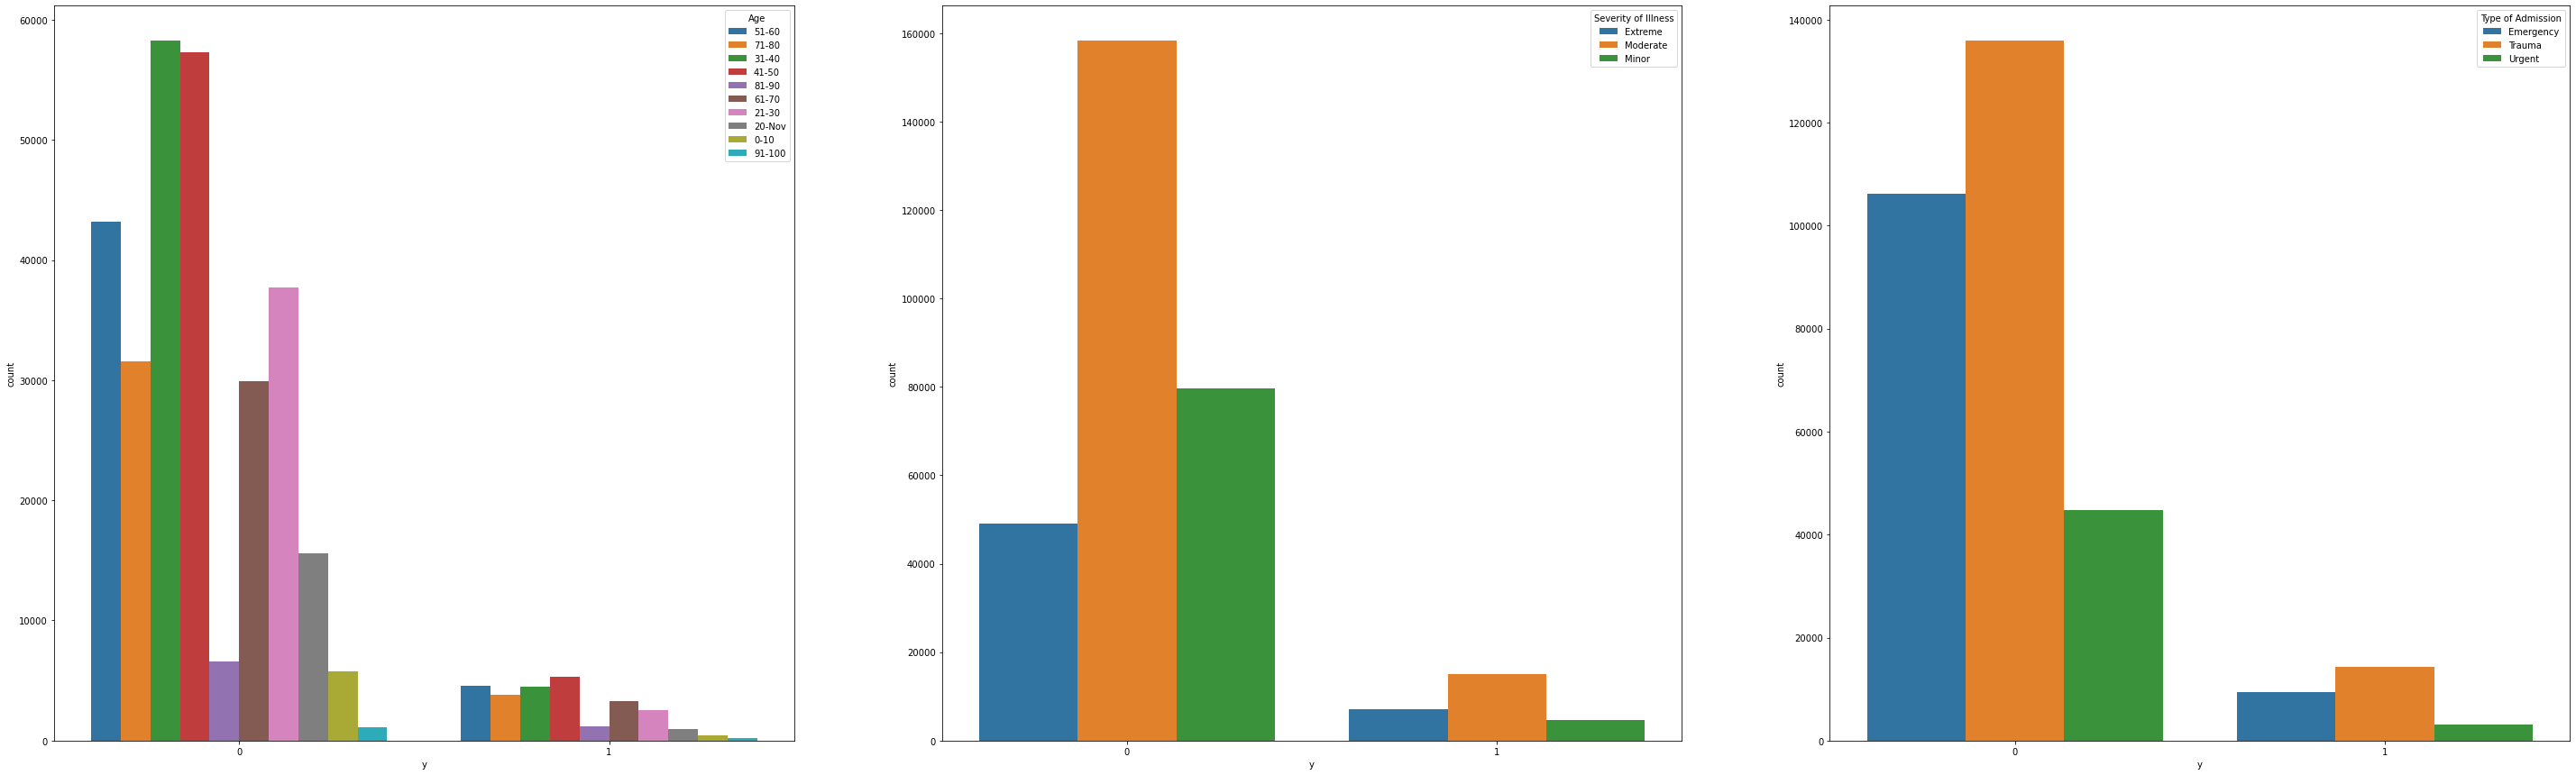

In [7]:
# plot for categorical parameters
import matplotlib.pyplot as plt
import seaborn as sns

_,axss = plt.subplots(1,3, figsize=[50,15],squeeze = False)
sns.countplot(x='y', hue='Age', data=data, ax=axss[0][0])
sns.countplot(x='y', hue='Severity of Illness', data=data, ax=axss[0][1])
sns.countplot(x='y', hue='Type of Admission', data=data, ax=axss[0][2])


In [8]:
# split dataset
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, stratify = y, random_state=1) #stratified sampling

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')


training data has 219655 observation with 6 features
test data has 94138 observation with 6 features


In [9]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):  
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['Type of Admission']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])
X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)

categories = ['Severity of Illness']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])
X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)

categories = ['Age']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])
X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)


In [10]:
X_train.head()

# define numerical & categorical data
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')]
num_cols


Index(['Available Extra Rooms in Hospital', 'Visitors with Patient',
       'Admission_Deposit'],
      dtype='object')

In [11]:
# standardization (x-mean)/std

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [12]:
X_train.head()

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit,Type of Admission_Emergency,Type of Admission_Trauma,Type of Admission_Urgent,Severity of Illness_Extreme,Severity of Illness_Minor,Severity of Illness_Moderate,Age_0-10,Age_20-Nov,Age_21-30,Age_31-40,Age_41-50,Age_51-60,Age_61-70,Age_71-80,Age_81-90,Age_91-100
0,-1.026683,-0.727009,0.187687,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.167708,7.212832,1.773780,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.691267,-0.727009,0.296185,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.026683,-0.727009,1.089691,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.167708,-0.727009,-0.597544,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Training

In [13]:
## predictive analytics
# build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

# function choosing hyperparameter & CV
from sklearn.model_selection import GridSearchCV
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))


In [14]:
## logistic
classifier_logistic = LogisticRegression()
classifier_logistic.fit(X_train, y_train)
classifier_logistic.predict(X_test)
classifier_logistic.score(X_test, y_test)


0.9246637914550978

In [15]:
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01, 0.05, 0.1, 0.2, 1)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': (0.01, 0.05, 0.1, 0.2, 1),
                         'penalty': ('l1', 'l2')})

In [16]:
print_grid_search_metrics(Grid_LR)

Best score: 0.9256424848057181
Best parameters set:
C:0.01
penalty:l2


In [17]:
best_LR_model = Grid_LR.best_estimator_

In [18]:
best_LR_model

LogisticRegression(C=0.01, solver='liblinear')

In [19]:
## KNN
# Choose k
parameters = {
    'n_neighbors':[1,3,5]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5]})

In [20]:
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.91751155220687
Best parameters set:
n_neighbors:5


In [21]:
best_KNN_model = Grid_KNN.best_estimator_

In [22]:
best_KNN_model

KNeighborsClassifier()

In [23]:
## Random Forest
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [60,80,100],
    'max_depth': [1,5,10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [60, 80, 100]})

In [24]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.9255059069905078
Best parameters set:
max_depth:10
n_estimators:100


In [25]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

In [26]:
best_RF_model

RandomForestClassifier(max_depth=10)

### Model performance

In [27]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
import matplotlib.pyplot as plt


       0     1
0  85293   800
1   6307  1738


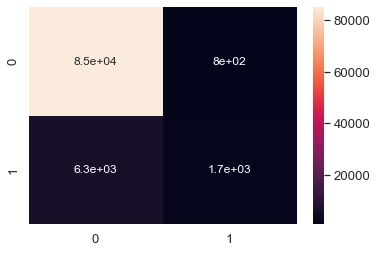

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     86093
           1       0.68      0.22      0.33      8045

    accuracy                           0.92     94138
   macro avg       0.81      0.60      0.64     94138
weighted avg       0.91      0.92      0.91     94138



In [28]:
## logistic regression
cm = confusion_matrix(y_test, best_LR_model.predict(X_test))
df_cm = pd.DataFrame(cm)
print(df_cm)
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
    
#Print classification report
cls = classification_report(y_test, best_LR_model.predict(X_test))
print(cls)

In [29]:
classifier_logistic.score(X_test, y_test)

0.9246637914550978

       0     1
0  84412  1681
1   6122  1923


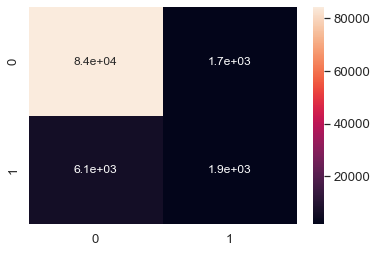

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     86093
           1       0.53      0.24      0.33      8045

    accuracy                           0.92     94138
   macro avg       0.73      0.61      0.64     94138
weighted avg       0.90      0.92      0.90     94138



In [30]:
## KNN
cm = confusion_matrix(y_test, best_KNN_model.predict(X_test))
df_cm = pd.DataFrame(cm)
print(df_cm)
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
    
#Print classification report
cls = classification_report(y_test, best_KNN_model.predict(X_test))
print(cls)

In [31]:
best_KNN_model.score(X_test, y_test)

0.9171110497354947

       0     1
0  85626   467
1   6627  1418


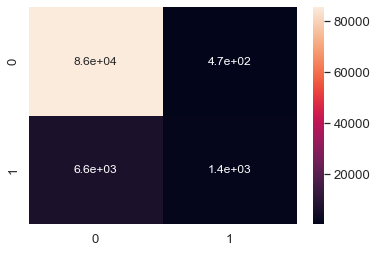

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     86093
           1       0.75      0.18      0.29      8045

    accuracy                           0.92     94138
   macro avg       0.84      0.59      0.62     94138
weighted avg       0.91      0.92      0.90     94138



In [32]:
## random forest
cm = confusion_matrix(y_test, best_RF_model.predict(X_test))
df_cm = pd.DataFrame(cm)
print(df_cm)
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
    
#Print classification report
cls = classification_report(y_test, best_RF_model.predict(X_test))
print(cls)

In [33]:
best_RF_model.score(X_test, y_test)

0.9246425460494169

In [34]:
# Plot ROC & AUC

In [35]:
from sklearn.metrics import roc_curve
from sklearn import metrics


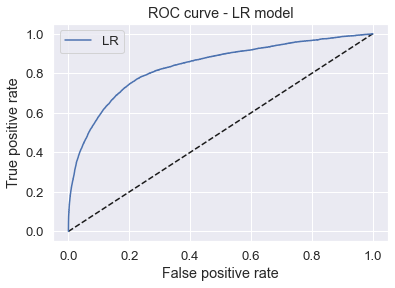

In [36]:
# Use predict probability to get results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

# ROC curve of Logistic Regression
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR model')
plt.legend(loc='best')
plt.show()

In [37]:
# AUC score LR
metrics.auc(fpr_lr,tpr_lr)

0.8359501909410595

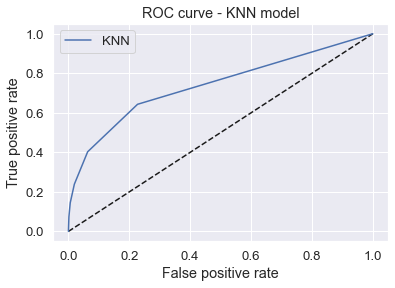

In [42]:
# Use predict probability to get results of KNN
y_pred_knn = best_KNN_model.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)

# ROC curve of KNN result
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - KNN model')
plt.legend(loc='best')
plt.show()

In [43]:
# AUC score KNN
metrics.auc(fpr_knn,tpr_knn)

0.7378444885907811

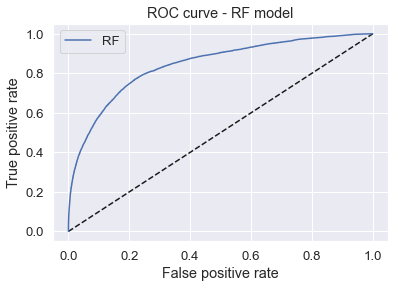

In [44]:
# Use predict probability to get results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# ROC curve of Random Forest result
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [45]:
# AUC score RF
metrics.auc(fpr_rf,tpr_rf)

0.8436683776935485

### Final result

From the above results, the random forest model has the best statistical result.